In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python
# coding: utf-8

import sys

sys.path.append('/dss/dsshome1/lxc0C/ge32luv/myenv/lib/python3.9/site-packages/')
sys.path.reverse()

import site
import importlib
import pkg_resources

site.addsitedir('/dss/dsshome1/lxc0C/ge32luv/myenv/lib/python3.9/site-packages/')

importlib.reload(pkg_resources)
pkg_resources.get_distribution('google-api-core')

import tensorflow as tf
import tensorflow_quantum as tfq
import sympy

import cirq
from cirq.contrib.svg import SVGCircuit
from cirq.circuits.qasm_output import QasmUGate
from tensorflow_quantum.python.layers.circuit_executors import expectation, sampled_expectation
from tensorflow_quantum.python.layers.circuit_construction import elementary
from tensorflow_quantum.python import util

import numpy as np
import random
import os
import struct
from array import array
from os.path  import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from PIL import Image, ImageFilter
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from datetime import datetime

import warnings

warnings.filterwarnings("ignore")
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)


2026-01-29 10:52:41.475706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64/openmpi/lib:/usr/local/cuda/lib64:/opt/intel/oneapi/redist/lib:/opt/postgresql/15.2/lib
2026-01-29 10:52:41.475730: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2026-01-29 10:52:47.089451: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-29 10:52:47.089492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (qlm): /proc/driver/nvidia/version does not exist
2026-01-29 10:52:47.090026: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep

In [2]:
import imgEncoder
import patchEncoder
from dataLoader import DataLoader
import callbacks
import pqcCNN

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [5]:
dataset = 'sat'
random_seed = 16
label_ratio = 0.1
weight_ratio = 5
locWeight = True

set_seed(random_seed)

print(f'dataset: {dataset}')
print(f'label_ratio: {label_ratio}, weight_ratio: {weight_ratio}')
print(f'locWeight: {locWeight}')

(3780, 32, 32, 4) (3780, 6) (420, 32, 32, 4) (420, 6) (1200, 32, 32, 4) (1200, 6) (1200, 32, 32, 4) (1200, 6)
['barren land', 'building', 'grassland', 'road', 'trees', 'water']


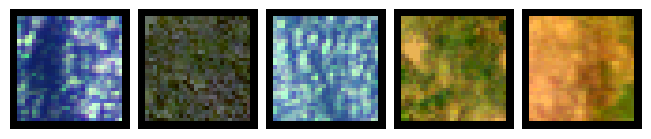

In [8]:
data = DataLoader(dataset, label_ratio)
unlabeled_train_x, unlabeled_train_y, labeled_train_x, labeled_train_y, valid_x, valid_y, test_x, test_y = data.get_data()
class_name = data.get_categories()

print(unlabeled_train_x.shape, unlabeled_train_y.shape, labeled_train_x.shape, labeled_train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape)
print(class_name)

def vis_samples(imgs):
    fig, axs = plt.subplots(1, len(imgs), layout='constrained')
    for i in range(imgs.shape[0]):
        img = imgs[i]
        sample = img[:, :, :3]
        axs[i].imshow(sample)
        axs[i].axis('off')
    plt.show()

vis_samples(test_x[:5])

In [9]:
if dataset == 'sat' or dataset == 'lcz':
    encoder_filters = [12]
    decoder_filters = [12]
    patch_size = 4
if dataset == 'eurosat':
    encoder_filters = [12, 16]
    decoder_filters = [16, 12]
    patch_size = 8
if dataset == 'patternet':
    encoder_filters = [12,16,20,24]  
    decoder_filters = [24,20,16,12]
    patch_size = 32        
input_shape =labeled_train_x.shape[1:] 
inputs = tf.keras.Input(shape=input_shape, name='input')
patches = patchEncoder.Patches(patch_size, input_shape, name='patch')(inputs)
encoder = patchEncoder.Encoder(encoder_filters, name='encoder')(patches)
decoder = patchEncoder.Decoder(decoder_filters, input_shape[-1], name='decoder')(encoder)
reconstruct = patchEncoder.Unpatch((patch_size, patch_size, input_shape[-1]), input_shape, name='reconstruction')(decoder)

if locWeight:
    qpc_layer = pqcCNN.allEntEncodingPQC_u3loc(name='pqc')(encoder)
if not locWeight:
    qpc_layer = pqcCNN.allEntEncodingPQC_woLoc(name='pqc')(encoder)
prediction = tf.keras.layers.Dense(labeled_train_y.shape[1], activation='softmax', name='classifier')(qpc_layer)
qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[prediction, reconstruct])
print(qcnn_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 4)]  0           []                               
                                                                                                  
 patches (Patches)              (None, 8, 8, 4, 4,   0           ['input[0][0]']                  
                                4)                                                                
                                                                                                  
 encoder (Encoder)              (None, 8, 8, 9)      645         ['patches[0][0]']                
                                                                                                  
 pqc (allEntEncodingPQC_u3loc)  (None, 64)           198         ['encoder[0][0]']            

In [10]:
paraToken = qcnn_model.layers[2].count_params() + qcnn_model.layers[4].count_params()
paraClassifier = qcnn_model.layers[5].count_params()
paraFeature = qcnn_model.layers[3].count_params()

print(paraToken, paraClassifier, paraFeature)


1321 390 198


In [11]:
import tensorflow.keras.backend as K

batch_size = 50
lr = 0.01
    
alpha = K.variable(1.0)
beta = K.variable(1.0*weight_ratio)


losses = {"classifier": "categorical_crossentropy", "reconstruction": "mse"}
lossWeights = {"classifier": alpha, "reconstruction": beta}
metrics = {'classifier': 'accuracy'}


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                   loss=losses, loss_weights=lossWeights, metrics=metrics)


In [ ]:
early_stopper = callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True, warmup=0)


history = qcnn_model.fit(x=labeled_train_x,
                         y={"classifier": labeled_train_y, "reconstruction": labeled_train_x},
                         batch_size=batch_size,
                         epochs=200,
                         verbose=2,
                         validation_data=(valid_x, {"classifier": valid_y, "reconstruction": valid_x}))


Epoch 1/200
9/9 - 63s - loss: 2.2009 - classifier_loss: 1.6313 - reconstruction_loss: 0.1139 - classifier_accuracy: 0.3286 - val_loss: 1.8449 - val_classifier_loss: 1.3046 - val_reconstruction_loss: 0.1080 - val_classifier_accuracy: 0.4133 - 63s/epoch - 7s/step
Epoch 2/200
9/9 - 47s - loss: 1.6613 - classifier_loss: 1.1315 - reconstruction_loss: 0.1060 - classifier_accuracy: 0.5143 - val_loss: 1.4853 - val_classifier_loss: 0.9937 - val_reconstruction_loss: 0.0983 - val_classifier_accuracy: 0.5317 - 47s/epoch - 5s/step
Epoch 3/200
9/9 - 52s - loss: 1.3516 - classifier_loss: 0.8844 - reconstruction_loss: 0.0934 - classifier_accuracy: 0.6548 - val_loss: 1.2108 - val_classifier_loss: 0.7902 - val_reconstruction_loss: 0.0841 - val_classifier_accuracy: 0.6600 - 52s/epoch - 6s/step
Epoch 4/200
9/9 - 52s - loss: 1.1064 - classifier_loss: 0.7117 - reconstruction_loss: 0.0789 - classifier_accuracy: 0.7429 - val_loss: 0.9766 - val_classifier_loss: 0.6223 - val_reconstruction_loss: 0.0708 - val_cl